# Lecture 11: Classification - 2

COMP 3921F \
Applied Machine Learning \
Mon 4:40 PM - 5:55 PM \
Tue: 5:00 PM - 6:15 PM

Professor: __Ramesh Natarajan__ \
Email: **ramesh.natarajan@yu.edu** \
Department of Computer Science \
Stern College and Yeshiva University

Date: Feb xx, 2024



## Acknowledgements

1. The starting point for developing the notebook-based instruction material was the set of notebooks provided by the previous  course instructor__[Prof. Zach Glassman](https://www.linkedin.com/in/zachary-glassman-7088844b/)__.
2. These notebooks have been augmented by similar instruction material taken from many, many other sources, including official documentation from many ML libraries and frameworks. I have adapted and modified the content where needed to make it compatible with student level, orientation and proficiency in this course.
3. The primary addition sources include:
   1. Course content from V. Kuleshov, Cornell Tech __[repo](https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/blob/main/notebooks/lecture1-introduction.ipynb)__.
   2. Book and support material from Hal Daume II, __[A course in Machine Learning](http://ciml.info)__. __[repo](https://github.com/hal3/ciml/)__
   3. Book and support material from A. Geron, __[Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (3rd edition)](https://homl.info/er3)__. __[repo](https://github.com/ageron/handson-ml3/blob/main/README.md)__




# Announcements

1. Problem Set 2 and 3 still open for submission.
2. Recitation will review Classification and Classification Metrics.
3. You should continue  to review and refresh yourself on the mathematical prerequisites for applied machine learning from part 1 for Deisenroth, Faisal and Ong, __[Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf)__.



# Classification  


<table>
    <td width="40%"><center>
        <img src="./img/Lecture-10/classification-creative.png" />      
    </center>
    Generated by Chat-GPT 
     </td>  
    <td>

 
In the previous lecture, we reviewed Logistic Regression and have reviewe a number of metrics that are widely used for evaluating classification model performance. 

The lecture will consider some practical issues that often arise in classification problem, including unbalanced data sets where there are very few examples of the class whose detection is of primary interest.
</td></table> 


# Unbalanced Problems

## What is the problem?

In many binary classificaiton applications, the training data examples are not balanced between the two classes, e.g. there is a  (*marjoity class*) with a large number of examples, and a  (*minority class*) with few examples.  Often it is the minority class which is of primary interest (i.e. fraud detection).  

Consider a data set  where 99% of the data is in the majority class.  An algorithm that predicts ALWAYS the majority class will have a default 99% acccuracy, even though it always misclassifies the minority class.  

The accuracy metric is therefore not very useful in this problem, and we will need metrics that focus on the correct classification of the minority class. 

Furthermore,  even with carefully chosen metrics, there may still be computational issues with model training for highly unbalanced data sets.  

To gain some intuition into this, lets look at the decision boundaries found by a simple LogisticRegression as a function of the relative imbalance of the classes.

**note**: to simplify details for expository purposes, we are not using train-test splits

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np
from random import uniform

def create_problem(weight: float, n_samples=100):
    if weight > 1:
        raise ValueError("Weight should be less than 1")
    rand = uniform(0, 1-weight)
    weights = [weight, rand, 1-weight-rand]
    return make_classification(n_samples=n_samples,
                               n_features=2, 
                               n_redundant=0,
                               n_repeated=0,
                               n_informative=2,
                               n_classes=3,
                               n_clusters_per_class=1,
                               weights=weights,
                               class_sep=1.2)

def train_and_plot(weight: float, title: str):
    X, y = create_problem(weight)
    print(pd.DataFrame({'target' : y}).groupby(y).size().reset_index(name='counts').drop(['index'], axis = 1))
    model = LogisticRegression().fit(X, y)
    disp = DecisionBoundaryDisplay.from_estimator(model, X, response_method='predict', alpha=.5)
    disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    plt.title(title)
    plt.show()


Plot the decision boundaries kwhen the number of examples in each class is balanced


   counts
0      51
1      38
2      11


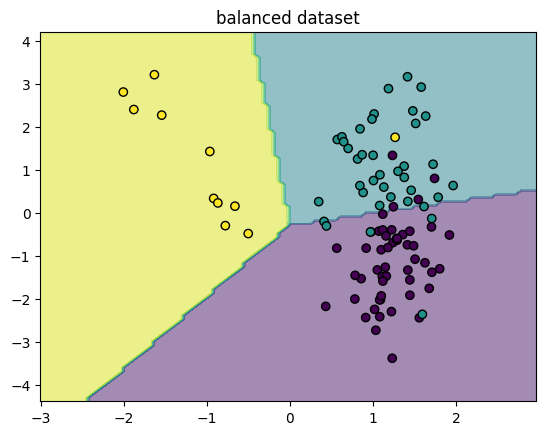

In [23]:

train_and_plot(.5, "balanced dataset")

Plot the decision boundaries kwhen the number of examples in each class is (mildly) unbalanced


   counts
0      91
1       2
2       7


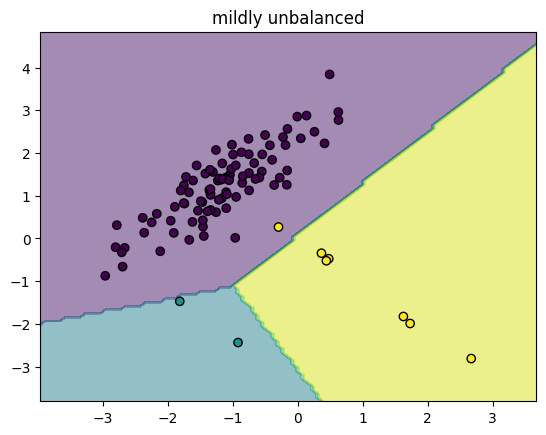

In [24]:
train_and_plot(.9, "mildly unbalanced")

   counts
0      95
1       4
2       1


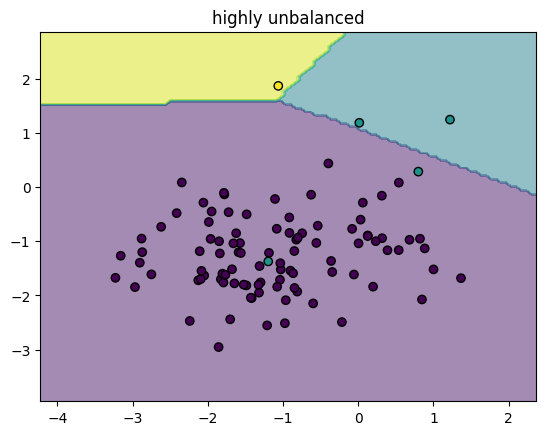

In [25]:
train_and_plot(.95, "highly unbalanced")

Notice that as the imbalance grows larger, the decision boundary becomes dominated by the majority class, in the extreme case it can even be hard to know where the proper boundary is by eye!

## How do we fix it?

There are a few ways to deal with imbalanced classes, described below:

-  Resampling data approaches which reshape the class distributions in the actual data  by upsampling the minority class and/or downsampling the majority class.
- Synthetic data approaches which either generate balanced class dataset with the same class distribution properties as the actual unbalanced data set.


One should attempt different approaches and see which one leads to the best results on the carefully chosen metrics of interest. 


We will be using the `imbalanced-learn` package which is  interoperable with scikit-learn, which provides  `fit_resample` method for data resampling. 

The `create_problem` function defined in an earlier cell is used to for generate data sets.



### Resampling Methods

#### Oversampling

Generate new examples by randomly sampling with replacement from the available data, and weighting the sampling procedure to generate more balanced data sets. 

The oversampling level can be used to move a dataset from 90/10 to 70/30 etc.

The challenges with oversampling are:

1. It increases the size of the dataset which increases the computational effort. 
2. Certain models are very sensitive to duplicate examples, so jittering must be used.
3. The resampling can alter the prior distribution of the minority class training data examples, e.g. geerated via jittering,  so that the resampled datasets are no longer representative of the test data. 

,original counts,resampled counts
0,91,91
1,2,91
2,7,91


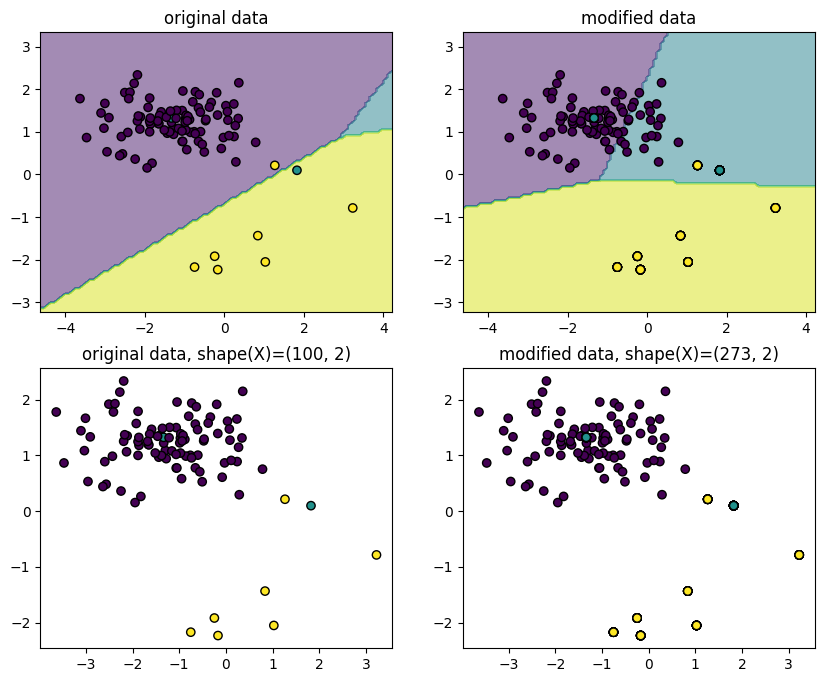

In [4]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

def sample(weight: float, clz, **kwargs):
    X, y = create_problem(weight)
    X_re, y_re = clz(**kwargs).fit_resample(X, y)

    df1 = pd.DataFrame({'original target' : y}).groupby(y).size().reset_index(name='original counts').drop(['index'], axis = 1)
    df2 = pd.DataFrame({'resampled target' : y_re}).groupby(y_re).size().reset_index(name='resampled counts').drop(['index'], axis = 1)
    display(pd.concat([df1, df2], axis = 1))
            
    model = LogisticRegression().fit(X, y)
    model_re = LogisticRegression().fit(X_re, y_re)

    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    disp = DecisionBoundaryDisplay.from_estimator(model, X, response_method='predict', alpha=.5, ax=ax[0, 0])
    disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    disp = DecisionBoundaryDisplay.from_estimator(model_re, X_re, response_method='predict', alpha=.5, ax=ax[0, 1])
    disp.ax_.scatter(X_re[:, 0], X_re[:, 1], c=y_re, edgecolor="k")

    
    ax[1, 0].scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
    ax[1, 1].scatter(X_re[:, 0], X_re[:, 1], c=y_re, edgecolor="k")
    ax[0, 0].set_title("original data")
    ax[0, 1].set_title("modified data")
    ax[1, 0].set_title(f"original data, shape(X)={X.shape}")
    ax[1, 1].set_title(f"modified data, shape(X)={X_re.shape}")
    
sample(.91, RandomOverSampler)

#### Oversampling with the smoothed bootstrap

The basic resampling algorithm creates copies of the examples, and it is possible to use a "smooted bootstrap" which "jitters" so that the resampled examples are slightly different from each other (with the dispersion of the individual examples controlled by a `shrinkage` parameter). 


,original counts,resampled counts
0,91,91
1,5,91
2,4,91


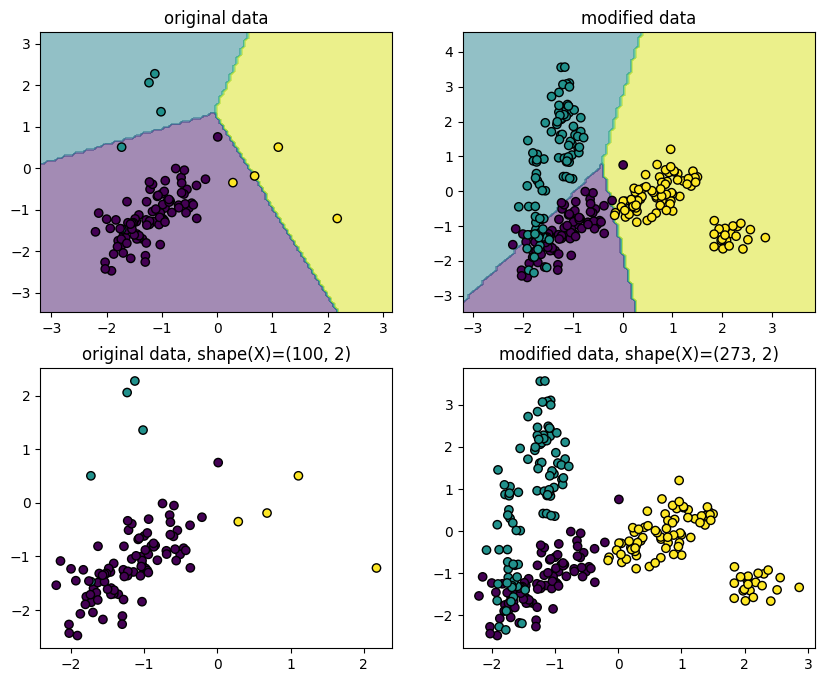

In [27]:
sample(.91, RandomOverSampler, shrinkage=.9)

#### Undersampling

Undersampling works by decreasing the example count of the majority class.  

The most basic approach is to just  randomly remove exaamples from our majority class.

One of the issues with this approach is that we might remove important data (so called `leverage` data points which have disproportionate impact on the model fitting).

,original counts,resampled counts
0,6,6
1,8,6
2,86,6


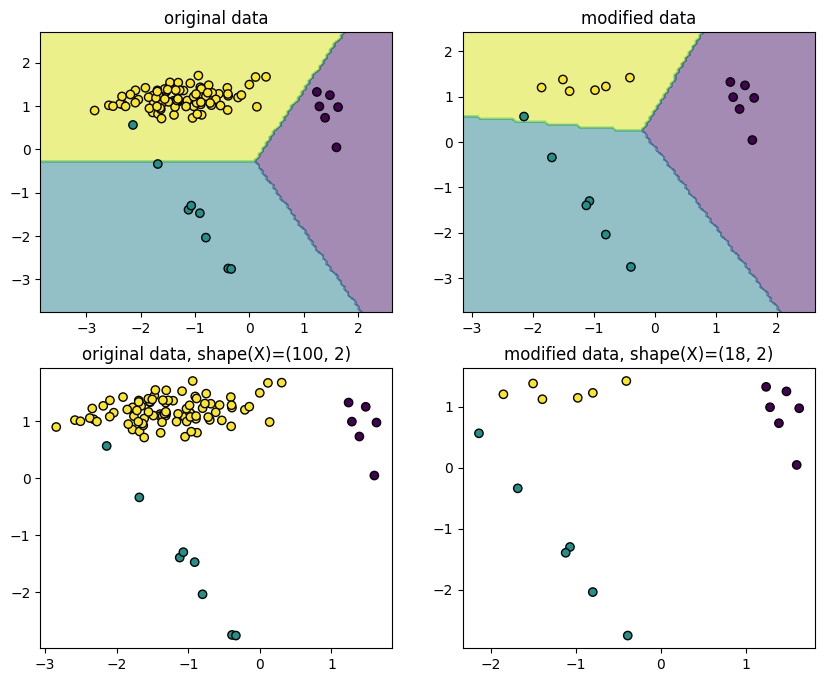

In [5]:
from imblearn.under_sampling import RandomUnderSampler

sample(.05, RandomUnderSampler)


#### Cluster sampling

A few other approaches have also been considered for reampling data.

One approach *generates* examples of the majority class instead of sampling the existing examples.  

A `ClusterCentroids` which uses the famous `K-means` algorithm can be used to create representative points  of the majority class,  These are not the original examples but some weighted combination of the original examples. 

,original counts,resampled counts
0,82,7
1,7,7
2,11,7


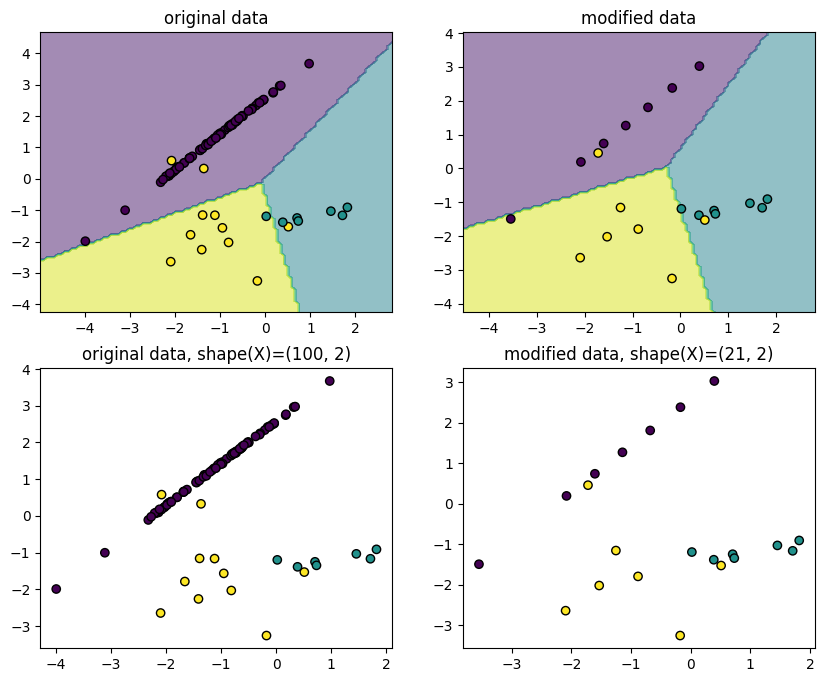

In [6]:
from imblearn.under_sampling import ClusterCentroids
import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import ClusterCentroids
sample(.81, ClusterCentroids)

#### Near-miss Sampling

This is a sampling approach that tries to keep "everage" examples in the resampled data if possible, while attempting to rebalance the class counts.

There are multiple versions of this approach:

- 1 - take examples with the smallest average distance to top-$K$ nearest  minority class examples
- 2 - take examples with the smallest average distinace to the top$-K$ furthest  minority class examples
- 3 - for each minority class example, take the top-$N$ nearest neighbors, then select the majority samples whose average distance to the top-$K$ nearest neighbors is largest.

The resulting resampled data sets are illustrated below.

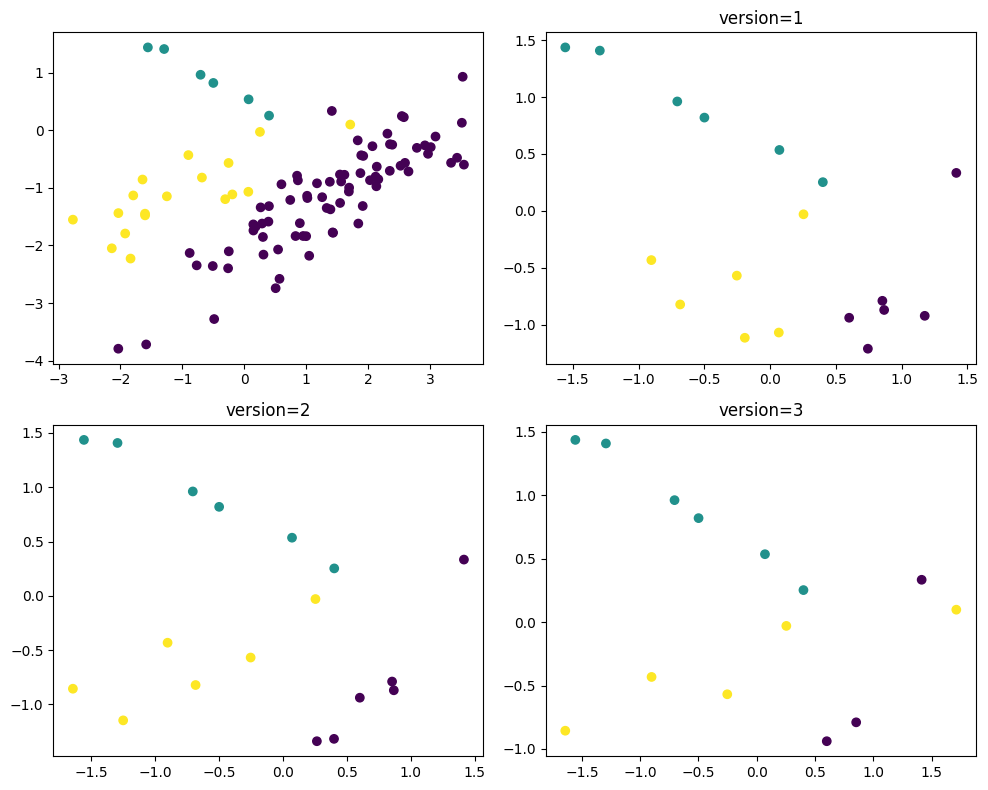

In [7]:
from imblearn.under_sampling import ClusterCentroids
import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import NearMiss
X, y = create_problem(.75)
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].scatter(X[:, 0], X[:, 1], c=y)
for i, ax_ind in enumerate([(0, 1), (1, 0), (1, 1)]):
    X_re, y_re = NearMiss(version=i+1).fit_resample(X, y)
    ax[ax_ind].scatter(X_re[:, 0], X_re[:, 1], c=y_re)
    ax[ax_ind].set_title(f"version={i+1}")
plt.tight_layout()

The advantages of this approach are that no synthetic data is creating while rebalancing the classes.   The training cost is also reduced due to the smaller data size.

The disadvantages are that we may still remove important data for modeling, and in general training a model with less data increases the parameter uncertainty. 


#### Combining Over and Under Sampling

The two approaches can be combined.  An initial oversampling can be used to create a larger balanced dataset, which can be undersampled back to its original size.   

### Synthetic Data Methods

Data Augmentation methods are used to  create new, synthetic examples of the minority class from the existing examples.

Here, intead of oversampling, the minority class examples are interpolated as follows:

1. Pick an example $x_i$
2. Choose its top-$K$ nearest neighbors
3. Choose one of these neighbors and create a new sample $x_{new}=x_i+\lambda (x_{zi} - x_i)$
4. Repeat

where $x_i$ is the chosen point, $x_{zi}$ is the chosen neighbor and $\lambda \in [0,1]$

Geometrically this is choosing a point on the line connecting the two points $x_i$, $x_{zi}$

Here is an example:
![https://imbalanced-learn.org/stable/_images/sphx_glr_plot_illustration_generation_sample_001.png](https://imbalanced-learn.org/stable/_images/sphx_glr_plot_illustration_generation_sample_001.png)

*source*: imbalanced-learn.org

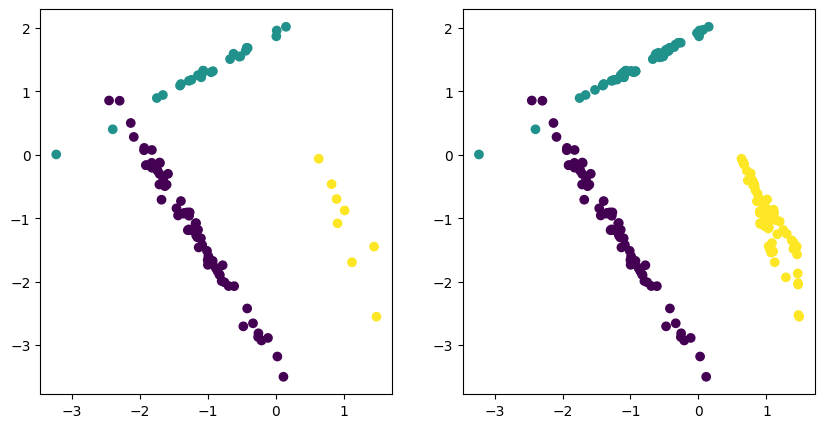

In [8]:
from imblearn.over_sampling import SMOTE
X, y = create_problem(.65)
X_re, y_re = SMOTE().fit_resample(X, y)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(X[:, 0], X[:, 1], c=y)
ax[1].scatter(X_re[:, 0], X_re[:, 1], c=y_re)

## Algorithm Modification for Imbalanced data

Some algorithms can be adjusted so that the  model metrics are aware of the imbalanced problem and they will be able to take the relative informational value of the classes into account.

### Algorithms that perform well

Some algorithms tend to perform better than others on imbalanced problems, for example tree based methods (i.e. Random Forest) can often do better.  This is due to the way that the common training algorithms work.  

### Penalized Classification

Some algorithms will contain a `class_weight` parameter which will make the loss function take the difference classes into account.  Lets use our imbalanced dataset to build up a dataset and do some fitting.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(*create_problem(.75, n_samples=1000))

model = LogisticRegression().fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))
print('***************')

model = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       192
           1       1.00      0.81      0.90        32
           2       0.66      0.81      0.72        26

    accuracy                           0.93       250
   macro avg       0.88      0.86      0.86       250
weighted avg       0.94      0.93      0.93       250

***************
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       192
           1       0.96      0.84      0.90        32
           2       0.55      0.81      0.66        26

    accuracy                           0.91       250
   macro avg       0.83      0.86      0.84       250
weighted avg       0.93      0.91      0.91       250



What you are doing is modifying the cost function to be different for different classes which will penalize mis classification of the rare class.

# Multi-Class Classification

In [29]:
import sklearn
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

(array([0.]), array([4.02420106, 2.94846016]))

In [ ]:
# extra code – it's a bit too long
print(mnist.DESCR)

In [ ]:
# extra code – it's a bit too long
print(mnist.DESCR)

In [ ]:
mnist.keys()

In [ ]:
X, y = mnist.data, mnist.target
X

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

In [ ]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [ ]:
# Data Augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

y augmenting the MNIST dataset by adding slightly shifted versions of each image.

In [ ]:
from scipy.ndimage import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]  # some random digit to demo
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

# Summary

This lecture describes a variety of techniques to handle **rare class** classification problems, using a variety of techniques including oversampling, undersampling and synthetic data methods. Broadly these are known as data augmentation methods. 

An alternative to data augmentation is to modify the loss functions used for model training to more heavily penalize the misclassification of the minority classes.   Broadly these are known as cost-sensitive learning methods.
